# Rain
<p>This notebook aims to develop some functions for dealing with precipitation in the model. In this notebook, I will cover:</p>
<p>
- Rain duration and total water volume<br>
- Rain infiltration into the ground<br>
- Overland flow<br>
- Predict hydrograph
</p>

## A bit about rain
<p>Since rainfall occurrence and amount is so variable, I can not easily create functions that would mimic any particular system. Rain is related to weather and climate, and often changes from year to year. Because of that, my model will use only isolated rain events initially.</p>
<p>Water infiltration into the ground is related to the hydraulic conductivity of the underlying material. Water can only infiltrate as fast as the conductivity allows. Any more than that will pile up on the surface. The first thing I would like to do is develop a function that gives the downward flow of water. As I use so often, I believe that the vertical rate of motion is determined by the hydraulic head differenc and vertical hydraulic conductivity (which is ususally much smaller than the horizontal). So, the governing equation for this function will be Darcy's Law:</p>
<h3><center>$Q = kA\frac{dh}{dL}$</center></h3>


In [1]:
def verticalDischarge(k2, h1, h2, L, x, y):
    '''
    Determines the discharge between vertical elements
    - k: hydraulic conductivity
    - h1,h2: hydraulic head of lower and upper elements
    - L: vertical length of the elements, effectively the distance between points
    - x,y: horizontal dimensions of the elements, A = x*y
    '''
    return k*x*y*(h2-h1)/L

## A simple rainstorm
<p>For the simplest rainstorm, I will use a constant rainfall rate. The rain begins falling at a constant rate and maintains that constant rate until the end, when the rain stops completely. A graph of the rainstorm would appear like the following:</p>

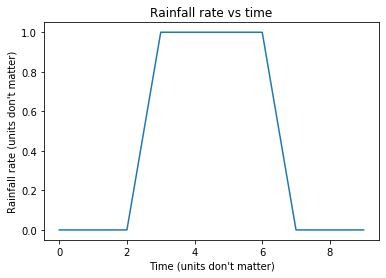

In [3]:
import numpy as np
import matplotlib.pyplot as plt
rate = np.zeros((10,1))
rate[3:7] = 1
plt.plot(rate)
plt.title("Rainfall rate vs time")
plt.xlabel("Time (units don't matter)")
plt.ylabel("Rainfall rate (units don't matter)")
plt.show()

<p>This should be a perfect step function, but whatever. The total amount of rain per unit area can be determined easily be integrating the function, but that's not really the important part here. What I want now is to model just a single square column and its response to rainfall. The column will have 10 layers for now, and each will have a finite volume of 1. I'll ust a hydraulic conductivity of .01 for now. The precipitation rate is larger than the infiltration rate, so the water should pile up on top of the square. What I don't know, however, is how that will affect the rate of infiltration below. For now, I'll just use it as .
<br>
This model is discretized, so I'll need a time step. Since this isn't a super quantitative model, the time step doesn't matter a whole lot. I'll just use a value of .1. Using the time step, I can calculate the amount of water that can be stored within a cube. I'll just set the total volume of a cube to 1.
</p>

### Set the initial column, top value, and queue to all zeros

In [18]:
column = np.zeros(10)
queue = np.zeros(10)
openWater = 0

### Initialize the other parameters

In [19]:
volume = 1
timeStep = .1
area = 1
k = .01
L = .1

### Set up rainfall rate

In [20]:
rainfallRate = .1

### Compute the top value

In [21]:
openWater += rainfallRate

### Compute flow to top element

In [22]:
dH = openWater - column[0]
waterChange = k*area*(dH/L)*timeStep
if (waterChange + column[0] > volume):
    column[0] = volume
    openWater -= (column[0]-waterChange)
else:
    column[0] += waterChange
    openWater -= waterChange

### Flow to the rest of the values

In [23]:
# First
queue[0] += (column[1] - column[0])*area*k*timeStep/L
if queue[0] + column[0] > volume:
    queue[0] = 1-column[0]
if column[0] = 1:
    queue[0] = 0

for i in range(1,9):
    queue[i] += (column[i + 1] - column[i])*area*k*timeStep/L
    queue[i] += (column[i - 1] - column[i])*area*k*timeStep/L
    if queue[i] + column[i] > volum:
        queue[i] = 1-column[i]
    if column[i] = 1:
        queue[i] = 0
    
# Last
queue[9] += (column[8] - column[9])*area*k*timeStep/L
if queue[9] + column[9] > volumn:
    queue[9] = 1-column[9]
if column[9] = 1:
    queue[9] = 0

[-0.001  0.001  0.     0.     0.     0.     0.     0.     0.     0.   ]


### Add queue to column and reset queue

In [24]:
column += queue
queue = np.zeros(10)

### Now, create a function to do all this

In [82]:
def updateColumn(column, k, L, timeStep, openWater, rainfallRate, volume, openVals):
    queue = np.zeros(column.size)
    length = column.size
    
    # Update open water
    openWater += rainfallRate
    
    # Top
    flow1 = (openWater - column[0])*(timeStep*k)/L
    if (column[0] <= volume):
        if (column[0] + flow1 > volume):
            flow1 = volume - column[0]
            openWater -= flow1
            queue[0] += flow1
        else:
            openWater -= flow1
            queue[0] += flow1
            
    # Middle
    for i in range(1,length-1):
        if column[i] <= volume:
            flowUp = (column[i + 1] - column[i]) * (timeStep*k)/L
            if (flowUp + column[i] > volume):
                flowUp = volume - column[i]
            else:
                queue[i] += flowUp
            flowDown = (column[i - 1] - column[i]) * (timeStep*k)/L
            queue[i] += flowDown
    
    # Bottom
    flow2 = (column[-2] - column[-1])*(timeStep*k)/L
    if (bottom <= volume):
        if (column[-1] + flow2 > volume):
            flow2 = volume - column[-1]
            queue[-2] -= flow2
            queue[-1] += flow2
        else:
            queue[-1] += flow2
            queue[-2] -= flow2
        
    column += queue
        
    openVals.append(openWater)
    return column, openVals, openWater
    

### Reset values and run function a lot

In [49]:
column = np.zeros(10)
queue = np.zeros(10)
k = .1
volume = 1
openWater = 0
openVals = []
for i in range(100):
    openVals.append(updateColumn(column, queue, k, L, area, timeStep, openWater, rainfallRate,volume))

print(column)

[0.06295772 0.06075709 0.06456052 0.06815015 0.0633409  0.06180471
 0.06580368 0.06742569 0.07443665 0.0738089 ]


### Plot Results

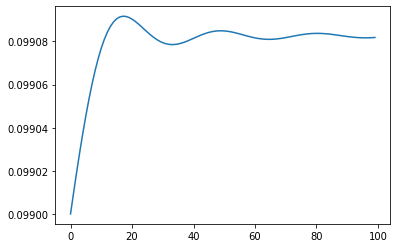

In [44]:
plt.plot(openVals)
plt.show()

In [61]:
L = .1
k = .1
timeStep = .1
volume = 1
openWater = 0
rainfallRate = .1
top = 0
topQ = 0
bottom = 0
bottomQ = 0

openVals = []

for i in range(60):
    # Update open water
    openWater += rainfallRate
    
    # Flow 1
    flow1 = (openWater - top)*(timeStep*k)/L
    if (top <= 1):
        if (top + flow1 > volume):
            flow1 = volume - top
            openWater -= flow1
            topQ += flow1
        else:
            openWater -= flow1
            topQ += flow1
    
    # Flow 2
    flow2 = (top - bottom)*(timeStep*k)/L
    if (bottom <= 1):
        if (bottom + flow2 > volume):
            flow2 = volume - bottom
            topQ -= flow2
            bottomQ += flow2
        else:
            bottomQ += flow2
            topQ -= flow2
        
    top += topQ
    bottom += bottomQ
    
    topQ = 0
    bottomQ = 0
        
    openVals.append(openWater)
    
print(openWater)
print(top)
print(bottom)

4.025699037511075
0.9976845668683078
0.9766163956206203


In [88]:
column = np.zeros(100)
openVals = []
openWater = 0
for i in range(200):
    column, openVals, openWater = updateColumn(column, 10, L, timeStep, openWater, rainfallRate, volume, openVals)
#print(column)

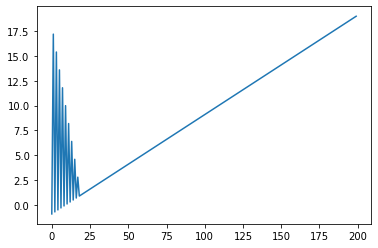

In [89]:
plt.plot(openVals)
plt.show()

## Current Progress
<p>At the moment, I don't think that this function is working greatly: honestly, I don't really know how accurate it is. At the moment, this is just a constant input of rainfall, which does not really reflect reality.<br>
On the agenda:<br>
- Set the water input at a constant value and the rainfall rate is dependent upon the timeStep. A larger time step would mean a greater input at each step, while a smaller one indicates a smaller one.<br>
- 
</p>